In [1]:
import os
import time
import warnings
import numpy as np
#import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# 경고 메시지 무시
warnings.filterwarnings(action='ignore')

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
## --- 분석 수행 및 결과 저장 클래스 선언 ---
class CrackAnalyzer:
    
    def __init__(self, modeldir):
        self.modeldir = modeldir
        self.elapsed_time = 0
        self.predict_list = []
        
    def analysis(self, input_list):
        
        with tf.Session() as sess:
            print("START : " + self.modeldir)
            
            #sess.run(tf.global_variables_initializer())
            
            # 모델 로딩
            tf.saved_model.loader.load(sess, ["serve"], self.modeldir)
            
            graph = tf.get_default_graph()
            
            x = graph.get_tensor_by_name("in:0")
            out = graph.get_tensor_by_name("pred:0")

            print('input_list : {}'.format(input_list.shape))
            print('out : {}'.format(out))
            
            # 모델 분석 수행
            start_time = time.time()
            _out = sess.run(out, feed_dict={x:input_list})
            end_time = time.time()
            
            self.elapsed_time = end_time - start_time            
            self.predict_list = _out
                
            print("END : " + self.modeldir)
            
            return self.predict_list

In [3]:
## --- 학습 결과 및 라벨 데이터 변환 함수 ---
def change_to_image(label, pred):
    
    rgb_pred = []
    rgb_label = []
    
    # 예측 데이터와 라벨 데이터의 0~1 값을 0~255 값으로 변환
    for x in range(512):
        for y in range(512):
            
            pred_row = [int(pred[x][y] * 255)]
            label_row = [int(label[x][y] * 255)]
            
            rgb_pred.append(pred_row)
            rgb_label.append(label_row)

    pred = np.array(rgb_pred).reshape([512,512,1])
    label = np.array(rgb_label).reshape([512,512,1])
    
    return pred, label

In [4]:
## --- 분석 결과 이미지 출력 함수 ---
def draw_plot_segmentation(image, pred, label):
    
    # pyplot의 현재 전체 이미지 크기를 백업 후 설정함
    tmp_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = (15,7)  # 너비, 높이 (in)
    
    # 원본 데이터 출력
    plt.subplot(1,3,1)  # 한 번에 여러 그래프 출력
    plt.imshow(image.reshape([512,512]), cmap='gray')
    plt.axis('off')
    
    # 예측 데이터 출력
    plt.subplot(1,3,2)
    plt.imshow(pred.reshape([512,512]), cmap='gray')
    plt.axis('off')
    
    # 라벨 데이터 출력
    plt.subplot(1,3,3)
    plt.imshow(label.reshape([512,512]), cmap='gray')
    plt.axis('off')  

    plt.show()
    plt.close()
    
    # 백업된 pyplot 이미지 크기를 복원함
    plt.rcParams["figure.figsize"] = tmp_size

In [5]:
## --- 분석할 데이터 로딩 ---
# 데이터 구조
# train_list : 학습용 데이터(이미지 개수, 448, 448, 1)
# label_list : 학습용 라벨 데이터(이미지 개수, 448, 448, 1)

# 학습 데이터 파일명
train_list_file = "/src/data/crack/Cracks/resize/imgs_crack_train.npy"
# 라벨 데이터 파일명
label_list_file = "/src/data/crack/Cracks/resize/labels_crack_train.npy"

print("load train data: ", train_list_file) 
train_list = np.load(train_list_file, allow_pickle=True)
print("load complete")

print("load train label data: ", label_list_file)
label_list = np.load(label_list_file, allow_pickle=True)
print("load complete")

print(train_list.shape)
print(label_list.shape)

load train data:  /src/data/crack/Cracks/resize/imgs_crack_train.npy
load complete
load train label data:  /src/data/crack/Cracks/resize/labels_crack_train.npy
load complete
(2924, 512, 512, 1)
(2924, 512, 512, 1)


In [6]:
## --- 분석 데이터에서 분석 수행용 데이터 일부 추출 ---
# 분석 데이터 설정
# 분석할 데이터 개수
analysis_count = 10
# 분석 데이터 중 최초 데이터 위치 
#base_index = np.random.randint(label_list.shape[0] - analysis_count)

# 150, 160, 300, 2000
# 10, 300, 400
base_index = 10

# 분석용 데이터와 라벨
analysis_x = train_list[base_index:base_index + analysis_count]
analysis_y = label_list[base_index:base_index + analysis_count]
print('analysis_x : {}'.format(analysis_x.shape))

analysis_x : (10, 512, 512, 1)


In [7]:
## --- 분석 모델 로딩 및 분석 수행 ---
# 분석 모델
modeldir = "/src/temp/model/UNET/CRACK-UNET-105"

analyzer = CrackAnalyzer(modeldir)
predict_list = analyzer.analysis(analysis_x)
print(predict_list.shape)

START : /src/hyebin/model/UNET/CRACK-UNET-115
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from /src/hyebin/model/UNET/CRACK-UNET-115/variables/variables
input_list : (10, 512, 512, 1)
out : Tensor("pred:0", shape=(?, 512, 512, 1), dtype=float32)
END : /src/hyebin/model/UNET/CRACK-UNET-115
(10, 512, 512, 1)


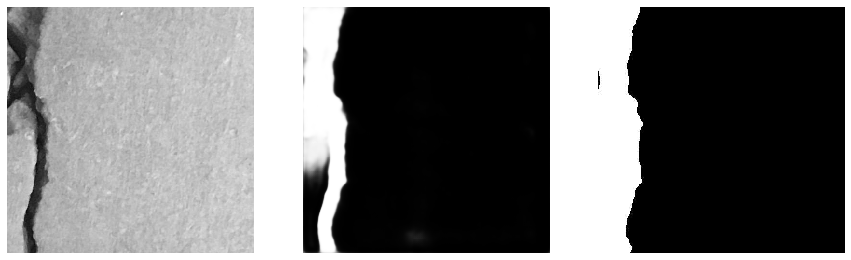

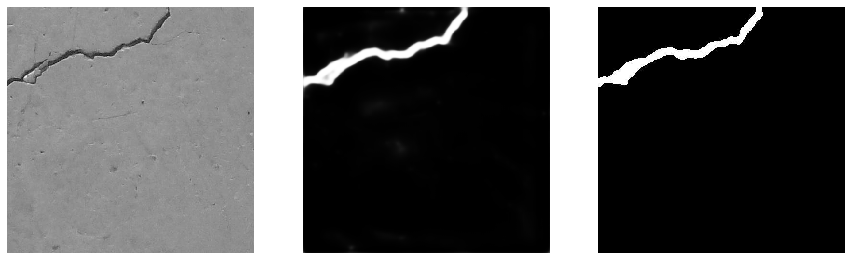

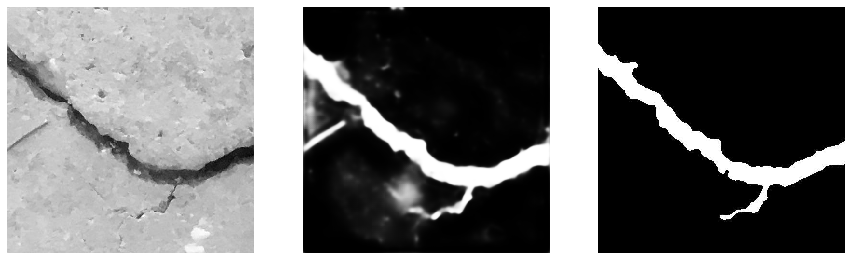

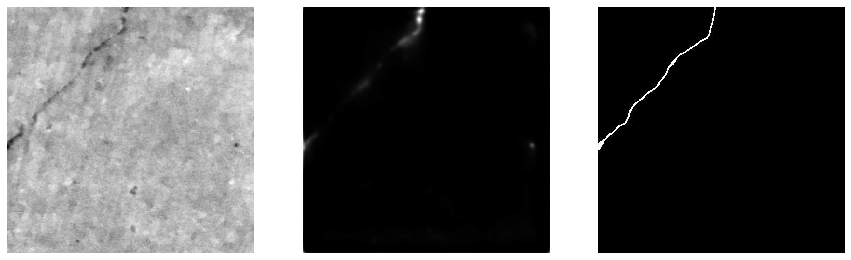

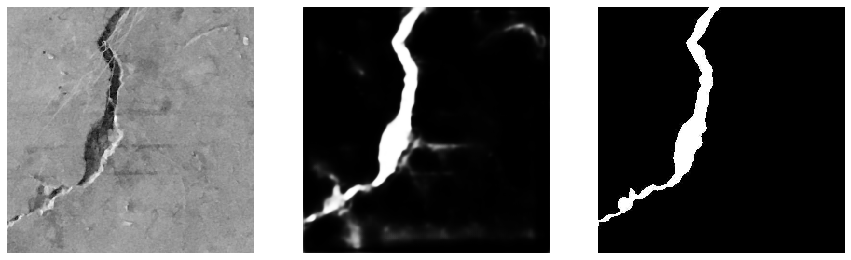

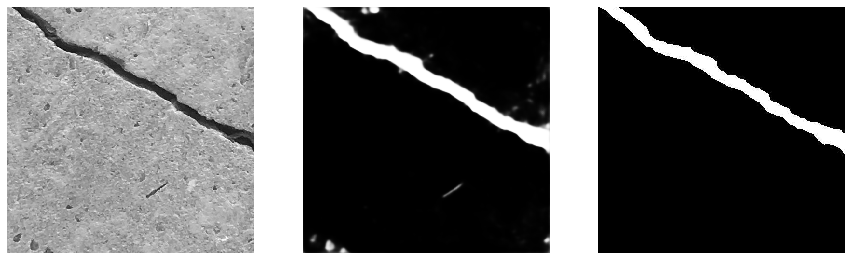

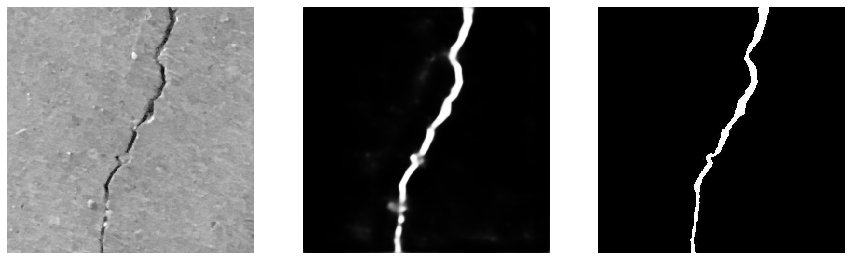

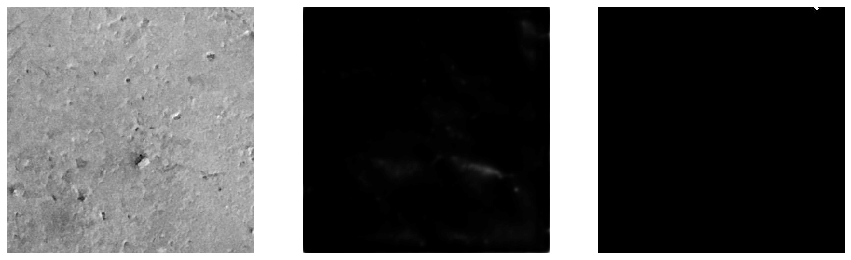

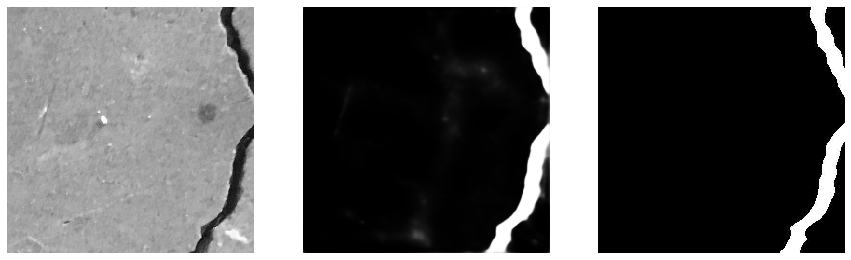

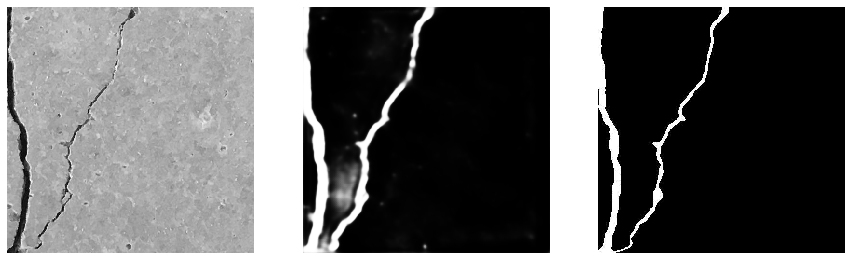

In [8]:
## --- 분석 결과 출력 ---
pred_data = []
label_data = []

# 예측 이미지와 라벨 이미지 화면 출력을 위한 변환 
for i in range(predict_list.shape[0]):
    _pred, _label = change_to_image(analysis_y[i], predict_list[i])
    pred_data.append(_pred)
    label_data.append(_label)

# 분석 결과 이미지 출력
for i in range(predict_list.shape[0]):
    draw_plot_segmentation(analysis_x[i], pred_data[i], label_data[i])